# Interpretability of pain behavior recognition

## First we need dataframes for every subject

In [14]:
import sys
sys.path.append('../')

%matplotlib inline

# DEFINE GRAPH
import pandas as pd
import numpy as np
import utils

from importlib import reload
reload(utils)

pd.set_option('max_colwidth', 800) 

In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
# Data paths
rgb_path = '../data/jpg_128_128_2fps/'
of_path = '../data/jpg_128_128_16fps_OF_magnitude_cv2/'

# Hyperparameters
input_width = 128
input_height = 128
seq_length = 10
seq_stride = 10
batch_size = 1
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

nb_input_dims = 5

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [20]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light, nb_input_dims)

In [21]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                 of_path=args.of_path,
                 clip_list_file='videos_overview_missingremoved.csv',
                 data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                 image_size=(args.input_height, args.input_width),
                 seq_length=args.seq_length,
                 seq_stride=args.seq_stride,
                 batch_size=args.batch_size,
                 color=COLOR,
                 nb_labels=args.nb_labels,
                 aug_flip=args.aug_flip,
                 aug_crop=args.aug_crop,
                 aug_light=args.aug_light,
                 nb_input_dims=args.nb_input_dims)

In [22]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/


In [7]:
subject_dfs = utils.read_or_create_subject_rgb_and_OF_dfs(dh, args, subject_ids, subject_dfs)

## Now that we have frames from all subjects, we can import gradcam functionality

In [10]:
# Choose a model to work on
two_stream = True

if two_stream: # This model got 88.09 % F1-score
    best_model_path = '../models/BEST_MODEL_2stream_5d_add_adadelta_LSTMunits_32_CONVfilters_16_add_v4_t5_4hl_128jpg2fps_seq10_bs8_MAG_adadelta_noaug_run1_rerun_gc.h5'

import keras
m = keras.models.load_model(best_model_path)

In [11]:
from keras import backend as K
import tensorflow as tf
    
images = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
flows = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, args.seq_length, 2])

if two_stream:
    clstm_model = utils.TwoStreamCLSTMNetwork(images, flows, from_scratch=0, path=best_model_path)
else:
    clstm_model = utils.CLSTMNetwork(images, from_scratch=0, path=best_model_path)

sess = K.get_session()  # Grab the Keras session where the weights are initialized.

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(clstm_model.preds)), axis=1)
    
y_c = tf.reduce_sum(tf.multiply(clstm_model.dense, labels), axis=1)

print('model preds: ', clstm_model.preds)
print('cost: ', cost)
print('y_c: ', y_c)


    
if two_stream:
    target_conv_layer = clstm_model.clstm4_rgb # Choose which CLSTM-layer to study
    # target_conv_layer = clstm_model.clstm1_rgb # Choose which CLSTM-layer to study
    # target_conv_layer = clstm_model.merge # Choose which CLSTM-layer to study
else:
    target_conv_layer = clstm_model.clstm4 # Choose which CLSTM-layer to study
    
print('tcl: ', target_conv_layer)
print('TYPE tcl: ', type(target_conv_layer))
    
target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, [images, flows])[0]  # Guided backpropagation back to input layer

model preds:  Tensor("activation_2/Sigmoid:0", shape=(1, 10, 2), dtype=float32)
cost:  Tensor("mul_4:0", shape=(1, 2), dtype=float32)
y_c:  Tensor("Sum_3:0", shape=(1, 2), dtype=float32)
tcl:  Tensor("conv_lst_m2d_4_5/transpose_1:0", shape=(1, ?, 16, 16, 32), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tclg:  Tensor("gradients_2/time_distributed_4_5/transpose_grad/transpose:0", shape=(1, ?, 16, 16, 32), dtype=float32)


In [12]:
def run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True):
    with sess.as_default():

        # 2-stream
        if two_stream:
            prob = sess.run(clstm_model.preds,
                            feed_dict={images: batch_img,
                                       flows: batch_flow,
                                       K.learning_phase(): 0})

            print(prob)

            gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value =                 sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                          feed_dict={images: batch_img,
                                     flows: batch_flow,
                                     labels: batch_label,
                                     K.learning_phase(): 0})

            target_conv_layer_value = np.reshape(target_conv_layer_value,
                                             (1, 10, 16, 16, 32))
            target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                             (1, 10, 16, 16, 32))
            
        else:
            prob = sess.run(clstm_model.preds,
                            feed_dict={images: batch_img,
                                       K.learning_phase(): 0})

            print(prob)
            gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value =                 sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                          feed_dict={images: batch_img,
                          labels: batch_label,
                          K.learning_phase(): 0})
            target_conv_layer_value = np.reshape(target_conv_layer_value,
                                         (1, 10, 16, 16, 32))
            target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                         (1, 10, 16, 16, 32))


        utils.visualize_overlays(batch_img, target_conv_layer_value,
                           target_conv_layer_grad_value, batch_flow)


# Two-stream predictions for subject t5

Chose subject  5
Start index in subject dataframe:  773
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_2a/frame_000774.jpg     0
1  data/jpg_128_128_2fps/horse_6/6_2a/frame_000775.jpg     0
2  data/jpg_128_128_2fps/horse_6/6_2a/frame_000776.jpg     0
3  data/jpg_128_128_2fps/horse_6/6_2a/frame_000777.jpg     0
4  data/jpg_128_128_2fps/horse_6/6_2a/frame_000778.jpg     0
5  data/jpg_128_128_2fps/horse_6/6_2a/frame_000779.jpg     0
6  data/jpg_128_128_2fps/horse_6/6_2a/frame_000780.jpg     0
7  data/jpg_128_128_2fps/horse_6/6_2a/frame_000781.jpg     0
8  data/jpg_128_128_2fps/horse_6/6_2a/frame_000782.jpg     0
9  data/jpg_128_128_2fps/horse_6/6_2a/frame_000783.jpg     0
[[[0.6847488  0.30776048]
  [0.7405003  0.24354094]
  [0.82822967 0.43229303]
  [0.90649676 0.6017283 ]
  [0.9094234  0.66203374]
  [0.92005765 0.6204121 ]
  [0.93100435 0.5637248 ]
  [0.9444394  0.52257216]
  [0.9606813  0.5891075 ]
  [0.96792835 0.4440051 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


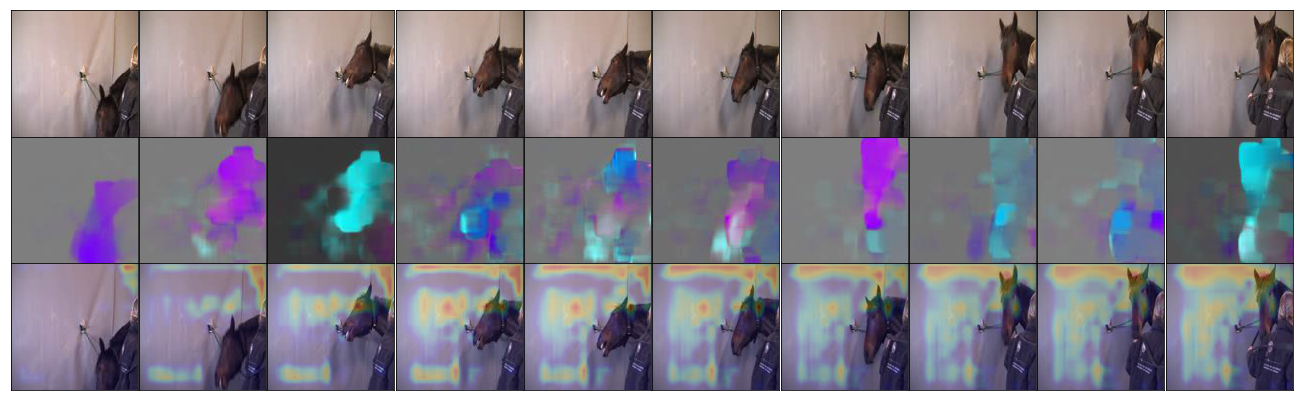

In [14]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  5
Start index in subject dataframe:  5724
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000331.jpg     1
1  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000332.jpg     1
2  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000333.jpg     1
3  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000334.jpg     1
4  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000335.jpg     1
5  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000336.jpg     1
6  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000337.jpg     1
7  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000338.jpg     1
8  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000339.jpg     1
9  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000340.jpg     1
[[[0.74469674 0.48639578]
  [0.7017999  0.6635169 ]
  [0.70222545 0.8654298 ]
  [0.5952209  0.8990989 ]
  [0.43957213 0.8939249 ]
  [0.32844734 0.89395297]
  [0.16594334 0.923643  ]
  [0.16205387 0.9322327 ]
  [0.11837921 0.9250601 ]
  [0.19833843 0.

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


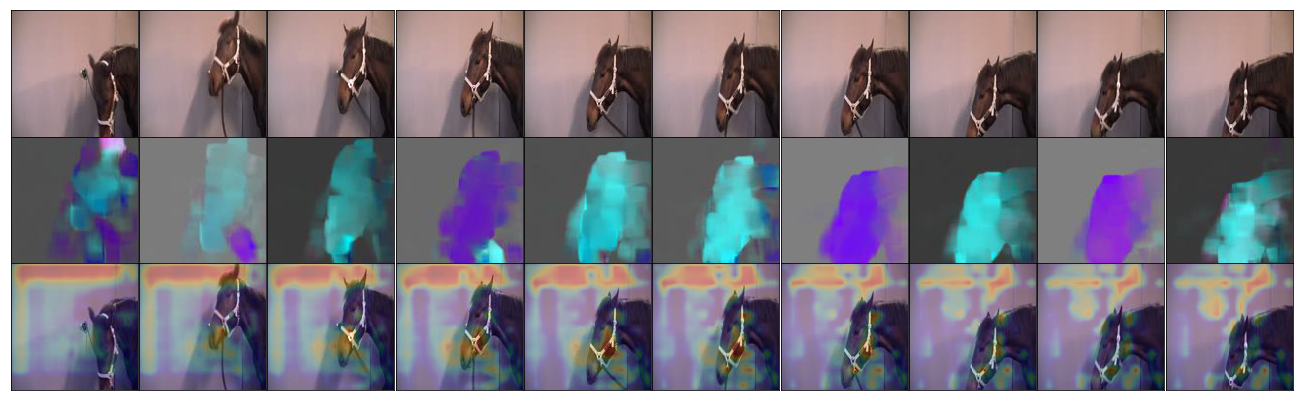

In [16]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  5
Start index in subject dataframe:  5531
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000138.jpg     1
1  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000139.jpg     1
2  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000140.jpg     1
3  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000141.jpg     1
4  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000142.jpg     1
5  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000143.jpg     1
6  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000144.jpg     1
7  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000145.jpg     1
8  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000146.jpg     1
9  data/jpg_128_128_2fps/horse_6/6_6a_1/frame_000147.jpg     1
[[[0.6107841  0.4329318 ]
  [0.55442405 0.44465733]
  [0.44921246 0.61964   ]
  [0.36012965 0.70373964]
  [0.2450125  0.7298744 ]
  [0.16969538 0.7574556 ]
  [0.07955329 0.78634626]
  [0.08511334 0.78834707]
  [0.15203607 0.7661291 ]
  [0.16611694 0.

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


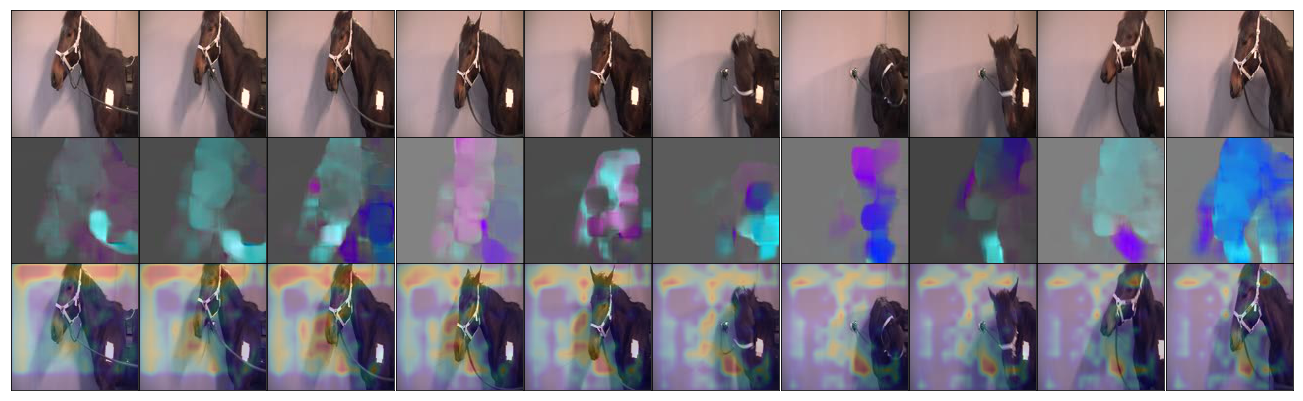

In [21]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  5
Start index in subject dataframe:  6322
                                                    Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_6a_2/frame_000029.jpg     1
1  data/jpg_128_128_2fps/horse_6/6_6a_2/frame_000030.jpg     1
2  data/jpg_128_128_2fps/horse_6/6_6a_2/frame_000031.jpg     1
3  data/jpg_128_128_2fps/horse_6/6_6a_2/frame_000032.jpg     1
4  data/jpg_128_128_2fps/horse_6/6_6a_2/frame_000033.jpg     1
5  data/jpg_128_128_2fps/horse_6/6_6a_2/frame_000034.jpg     1
6  data/jpg_128_128_2fps/horse_6/6_6a_2/frame_000035.jpg     1
7  data/jpg_128_128_2fps/horse_6/6_6a_2/frame_000036.jpg     1
8  data/jpg_128_128_2fps/horse_6/6_6a_2/frame_000037.jpg     1
9  data/jpg_128_128_2fps/horse_6/6_6a_2/frame_000038.jpg     1
[[[0.490744   0.34146962]
  [0.2591902  0.3234536 ]
  [0.15970273 0.41343322]
  [0.14082713 0.5539498 ]
  [0.10197333 0.6568196 ]
  [0.07112017 0.7673072 ]
  [0.07343085 0.76074016]
  [0.06554964 0.8227651 ]
  [0.08315971 0.878163  ]
  [0.06383377 0.

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


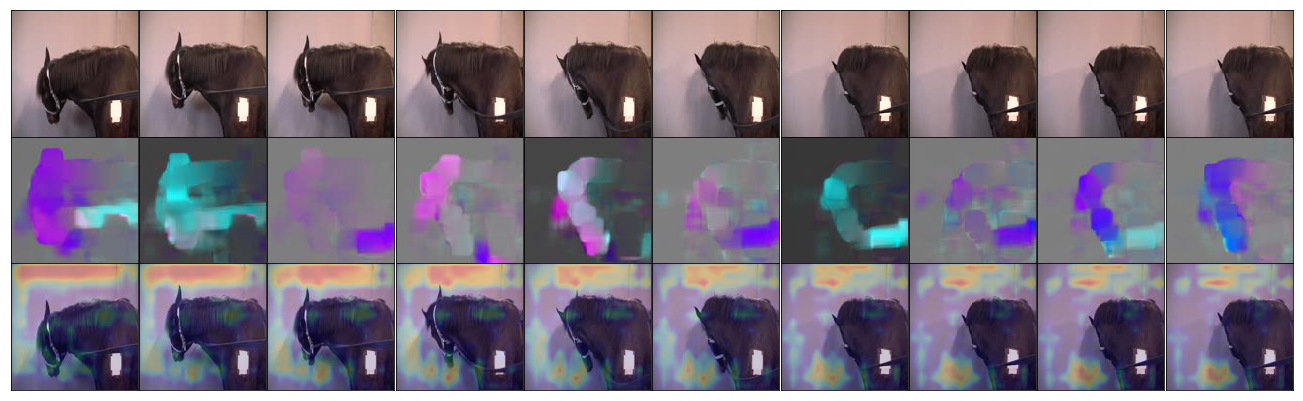

In [22]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  5
Start index in subject dataframe:  4029
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_4a/frame_000476.jpg     1
1  data/jpg_128_128_2fps/horse_6/6_4a/frame_000477.jpg     1
2  data/jpg_128_128_2fps/horse_6/6_4a/frame_000478.jpg     1
3  data/jpg_128_128_2fps/horse_6/6_4a/frame_000479.jpg     1
4  data/jpg_128_128_2fps/horse_6/6_4a/frame_000480.jpg     1
5  data/jpg_128_128_2fps/horse_6/6_4a/frame_000481.jpg     1
6  data/jpg_128_128_2fps/horse_6/6_4a/frame_000482.jpg     1
7  data/jpg_128_128_2fps/horse_6/6_4a/frame_000483.jpg     1
8  data/jpg_128_128_2fps/horse_6/6_4a/frame_000484.jpg     1
9  data/jpg_128_128_2fps/horse_6/6_4a/frame_000485.jpg     1
[[[0.5984335  0.64142025]
  [0.4846408  0.87920856]
  [0.39069337 0.9533536 ]
  [0.3773111  0.9786751 ]
  [0.2480594  0.9906446 ]
  [0.1495631  0.99159724]
  [0.10273311 0.9869092 ]
  [0.08123023 0.97761893]
  [0.10572095 0.9790344 ]
  [0.08982845 0.981326  ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


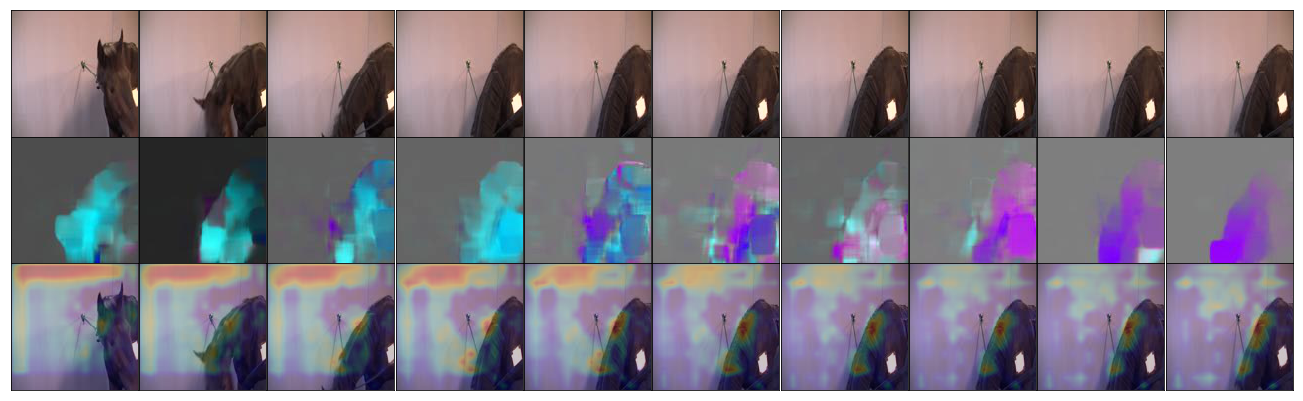

In [23]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  5
Start index in subject dataframe:  5017
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_4a/frame_001464.jpg     1
1  data/jpg_128_128_2fps/horse_6/6_4a/frame_001465.jpg     1
2  data/jpg_128_128_2fps/horse_6/6_4a/frame_001466.jpg     1
3  data/jpg_128_128_2fps/horse_6/6_4a/frame_001467.jpg     1
4  data/jpg_128_128_2fps/horse_6/6_4a/frame_001468.jpg     1
5  data/jpg_128_128_2fps/horse_6/6_4a/frame_001469.jpg     1
6  data/jpg_128_128_2fps/horse_6/6_4a/frame_001470.jpg     1
7  data/jpg_128_128_2fps/horse_6/6_4a/frame_001471.jpg     1
8  data/jpg_128_128_2fps/horse_6/6_4a/frame_001472.jpg     1
9  data/jpg_128_128_2fps/horse_6/6_4a/frame_001473.jpg     1
[[[0.61312973 0.33666086]
  [0.5326939  0.32046345]
  [0.56111723 0.49792168]
  [0.51849824 0.58011717]
  [0.39337364 0.626437  ]
  [0.2970199  0.62111306]
  [0.2005088  0.56858563]
  [0.14942956 0.47652215]
  [0.10104663 0.4664818 ]
  [0.05535623 0.5049413 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


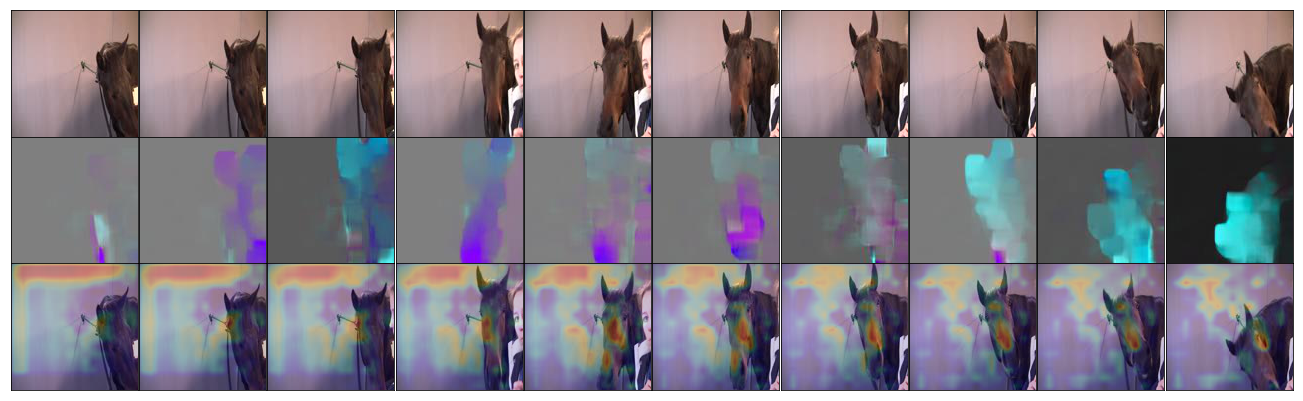

In [24]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  5
Start index in subject dataframe:  1971
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_2a/frame_001972.jpg     0
1  data/jpg_128_128_2fps/horse_6/6_2a/frame_001973.jpg     0
2  data/jpg_128_128_2fps/horse_6/6_2a/frame_001974.jpg     0
3  data/jpg_128_128_2fps/horse_6/6_2a/frame_001975.jpg     0
4  data/jpg_128_128_2fps/horse_6/6_2a/frame_001976.jpg     0
5  data/jpg_128_128_2fps/horse_6/6_2a/frame_001977.jpg     0
6  data/jpg_128_128_2fps/horse_6/6_2a/frame_001978.jpg     0
7  data/jpg_128_128_2fps/horse_6/6_2a/frame_001979.jpg     0
8  data/jpg_128_128_2fps/horse_6/6_2a/frame_001980.jpg     0
9  data/jpg_128_128_2fps/horse_6/6_2a/frame_001981.jpg     0
[[[0.6921941  0.42967796]
  [0.7373519  0.5049157 ]
  [0.8259248  0.46407914]
  [0.8539993  0.38970155]
  [0.8387099  0.29759136]
  [0.81915903 0.17633638]
  [0.6600013  0.14720953]
  [0.5663595  0.07550392]
  [0.61061573 0.05412956]
  [0.63271666 0.06739041]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


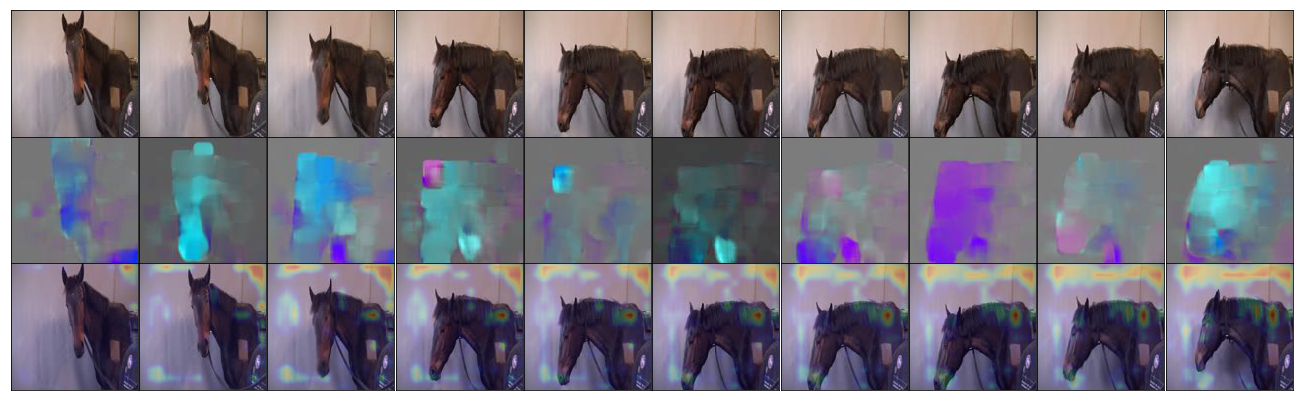

In [26]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  5
Start index in subject dataframe:  377
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_2a/frame_000378.jpg     0
1  data/jpg_128_128_2fps/horse_6/6_2a/frame_000379.jpg     0
2  data/jpg_128_128_2fps/horse_6/6_2a/frame_000380.jpg     0
3  data/jpg_128_128_2fps/horse_6/6_2a/frame_000381.jpg     0
4  data/jpg_128_128_2fps/horse_6/6_2a/frame_000382.jpg     0
5  data/jpg_128_128_2fps/horse_6/6_2a/frame_000383.jpg     0
6  data/jpg_128_128_2fps/horse_6/6_2a/frame_000384.jpg     0
7  data/jpg_128_128_2fps/horse_6/6_2a/frame_000385.jpg     0
8  data/jpg_128_128_2fps/horse_6/6_2a/frame_000386.jpg     0
9  data/jpg_128_128_2fps/horse_6/6_2a/frame_000387.jpg     0
[[[0.7874889  0.39800686]
  [0.797571   0.46603668]
  [0.7887563  0.52063257]
  [0.784954   0.60825896]
  [0.7688125  0.63120854]
  [0.77215433 0.48639628]
  [0.68054235 0.5144921 ]
  [0.5000993  0.42970797]
  [0.46308714 0.32655656]
  [0.5437807  0.22566932]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


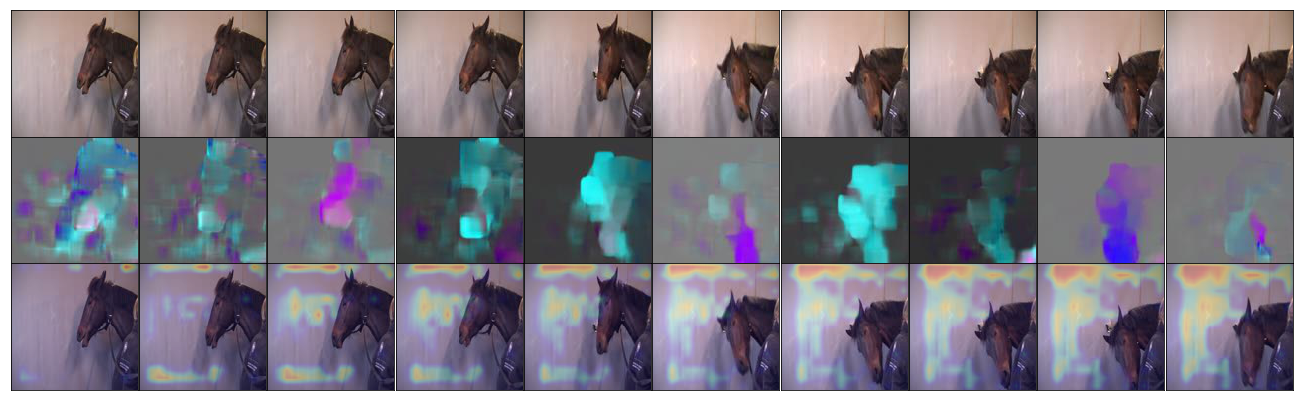

In [31]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  5
Start index in subject dataframe:  4798
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_4a/frame_001245.jpg     1
1  data/jpg_128_128_2fps/horse_6/6_4a/frame_001246.jpg     1
2  data/jpg_128_128_2fps/horse_6/6_4a/frame_001247.jpg     1
3  data/jpg_128_128_2fps/horse_6/6_4a/frame_001248.jpg     1
4  data/jpg_128_128_2fps/horse_6/6_4a/frame_001249.jpg     1
5  data/jpg_128_128_2fps/horse_6/6_4a/frame_001250.jpg     1
6  data/jpg_128_128_2fps/horse_6/6_4a/frame_001251.jpg     1
7  data/jpg_128_128_2fps/horse_6/6_4a/frame_001252.jpg     1
8  data/jpg_128_128_2fps/horse_6/6_4a/frame_001253.jpg     1
9  data/jpg_128_128_2fps/horse_6/6_4a/frame_001254.jpg     1
[[[0.6574785  0.3251108 ]
  [0.5346811  0.3100739 ]
  [0.36560366 0.34171727]
  [0.17452985 0.3858926 ]
  [0.1047963  0.44937754]
  [0.06154076 0.6093113 ]
  [0.02654207 0.71945643]
  [0.01815498 0.8763628 ]
  [0.01110973 0.91775876]
  [0.00977901 0.9119967 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


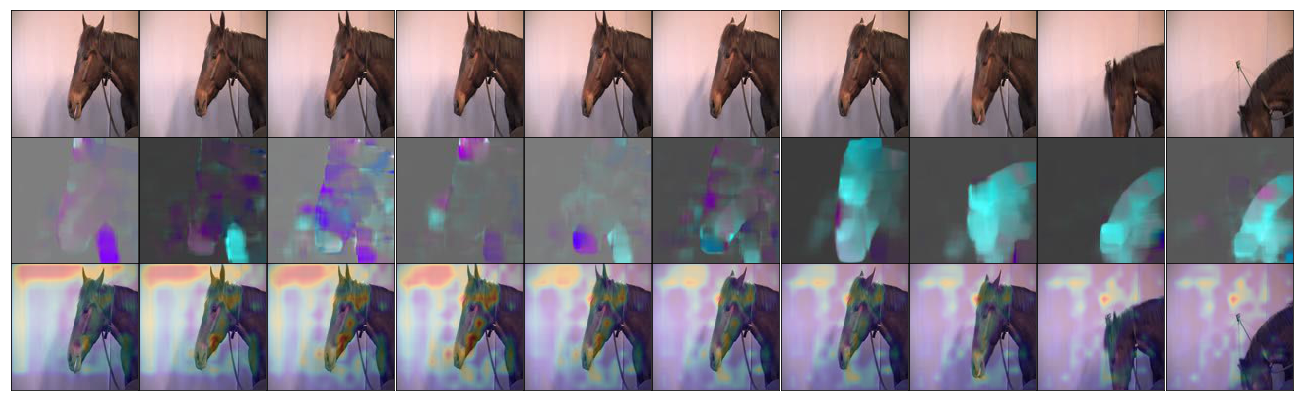

In [32]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  5
Start index in subject dataframe:  1453
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_2a/frame_001454.jpg     0
1  data/jpg_128_128_2fps/horse_6/6_2a/frame_001455.jpg     0
2  data/jpg_128_128_2fps/horse_6/6_2a/frame_001456.jpg     0
3  data/jpg_128_128_2fps/horse_6/6_2a/frame_001457.jpg     0
4  data/jpg_128_128_2fps/horse_6/6_2a/frame_001458.jpg     0
5  data/jpg_128_128_2fps/horse_6/6_2a/frame_001459.jpg     0
6  data/jpg_128_128_2fps/horse_6/6_2a/frame_001460.jpg     0
7  data/jpg_128_128_2fps/horse_6/6_2a/frame_001461.jpg     0
8  data/jpg_128_128_2fps/horse_6/6_2a/frame_001462.jpg     0
9  data/jpg_128_128_2fps/horse_6/6_2a/frame_001463.jpg     0
[[[0.6693252  0.29450655]
  [0.6712517  0.17510864]
  [0.719163   0.12914157]
  [0.7636816  0.1486937 ]
  [0.81146085 0.13250063]
  [0.83667815 0.10638437]
  [0.7500576  0.18831247]
  [0.7781705  0.2053462 ]
  [0.8039313  0.2481033 ]
  [0.83598065 0.27803528]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


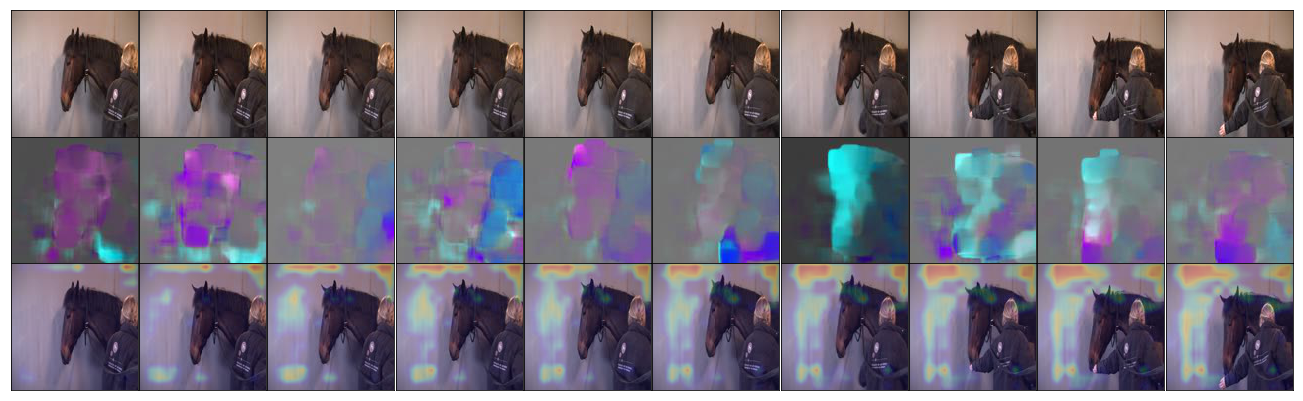

In [34]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  5
Start index in subject dataframe:  1555
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_6/6_2a/frame_001556.jpg     0
1  data/jpg_128_128_2fps/horse_6/6_2a/frame_001557.jpg     0
2  data/jpg_128_128_2fps/horse_6/6_2a/frame_001558.jpg     0
3  data/jpg_128_128_2fps/horse_6/6_2a/frame_001559.jpg     0
4  data/jpg_128_128_2fps/horse_6/6_2a/frame_001560.jpg     0
5  data/jpg_128_128_2fps/horse_6/6_2a/frame_001561.jpg     0
6  data/jpg_128_128_2fps/horse_6/6_2a/frame_001562.jpg     0
7  data/jpg_128_128_2fps/horse_6/6_2a/frame_001563.jpg     0
8  data/jpg_128_128_2fps/horse_6/6_2a/frame_001564.jpg     0
9  data/jpg_128_128_2fps/horse_6/6_2a/frame_001565.jpg     0
[[[0.6974074  0.33484375]
  [0.7686393  0.38915348]
  [0.7820252  0.2999234 ]
  [0.7565749  0.18139918]
  [0.7433067  0.12845938]
  [0.7680588  0.08375631]
  [0.75122905 0.0747836 ]
  [0.68279564 0.15017532]
  [0.733976   0.28531075]
  [0.7598914  0.3435121 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


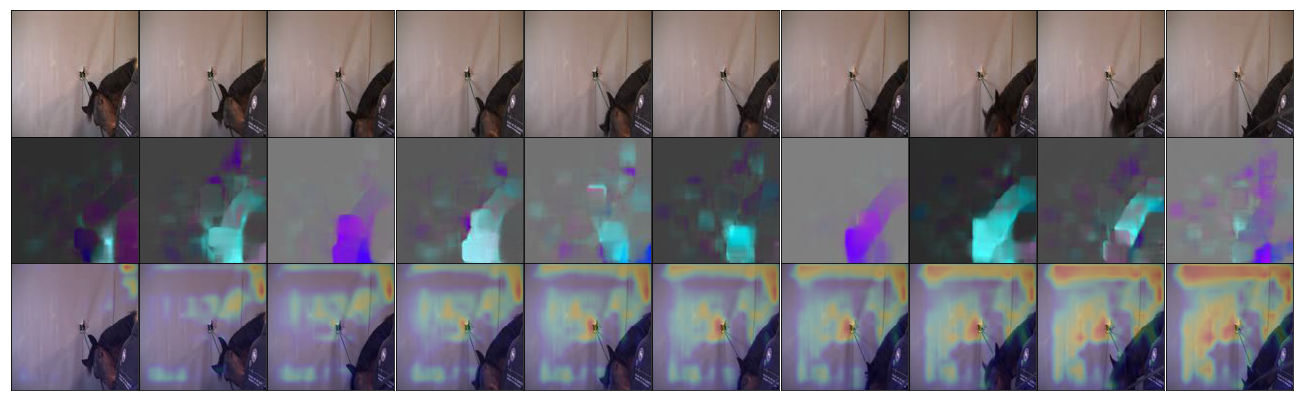

In [37]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=5)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);